<a href="https://colab.research.google.com/github/rigonzal/ML-2019-1/blob/master/Tarea2/Pregunta2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-393: Máquinas de Aprendizaje

## Tarea 2 - Pregunta 2: Regularización

16-08-2019



*   Rodrigo González Smith           -- 201303026-2
*   Ignacio Valenzuela Albornoz   -- 201473055-1

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from google.colab import drive
from operator import itemgetter
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive')

%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Introducción

* En esta pregunta analizaremos como combatir el fenómeno del *overfitting*, el cual corresponde al sobreajuste sobre el set de entrenamiento por parte de un modelo. Se verán 2 técnicas de regularización conocidas, y se estudiaran la variación de sus parámetros. Realizando un análisis de los resultados por medio de métricas y visualizaciones, todo el trabajo se realizará sobre el dataset de los precios de viviendas y sus características.

## 2.a  Carga y preprocesamiento.

* El set de datos corresponde a las características de viviendas de un sector de EEUU, donde cada una posee un precio asociado. Es intuitivo ver el interés por aplicar modelos predictivos en relación al *target*/precio.

* Se empieza por la carga de datos y la limpieza general del set de datos, como también un descripción general de este para tener más claridad.

In [2]:
df = pd.read_csv("/content/drive/My Drive/Universidad-varios/2019-1/ML/Tarea 2/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


* Transformamos la columna respectiva a la fecha en una codificación númerica, para facilitar el manejo posteriormente.

In [3]:
def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res
df['date'] = df.date.apply(to_num).rank()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10544.0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,13682.5,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,16699.0,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,13682.5,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,16276.0,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


* Procedemos a explicar cada columna según la información obtenida en [ Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction,):
  
  1) **Bedrooms:**  La cantidad de piezas que posee esa casa.
  
  2) **Bathrooms:**   La cantidad de baños que posee la casa. Se debe realizar un pequeño análisis en esta columna:

In [4]:
print(df.bathrooms.unique(), len(df.bathrooms.unique()))

[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ] 30


* El hecho de que existan decimales se debe a la notación especial americana para definir el número de baños, donde existen 3 tipos de estos:
  * Completos con bañera, ducha, lavamanos y retrete.
  * Los  '3/4',  ducha, lavamanos y retrete.
  * Los '1/2' retrete (ulala señor frances) y lavamanos. 
  
  Esta notación de igual manera puede llevar a confusión cuando existen combinatorias respecto a los baños.
  
  3)**sqft_living**: La medición de pies cuadrados de la casa, un dato que de antemano se ve de utilidad para una estimación del precio.
  
  4)**sqft_lot:** Medición en pies cuadrdos de la parcela completa. Mientras mas 'patio' posea una casa implica un valor más alto, ya que el terreno completo es mayor.
  
  5) **Floor:** Este atributo indica la cantidad de pisos. También tiene un valor decimal en la cual no hay información que explique. A primera instancia podría referirse a la presencia de un sótano, pero no concuerda con los valores de la columna **sqft_basement**, donde en muestras donde existe un sótano, los pisos no presentan un valor decimal. Podría suponerse también a una alcoba, pero los americanos generalmente denominan a eso también como un sótano.

In [5]:
print(df.floors.unique())

[1.  2.  1.5 3.  2.5 3.5]


* Se prosigue con la explicación de las columnas:

  6) **Waterfront**:  Indica si la vivienda posee vista al mar.
  
  7) **View:** Según la descripción, es si la casa a sido vista por otro comprador o no. Como no es una variable binaria y va desde 0 a 4, se supondrá que indica la cantidad de veces que han visto esa vivienda.
  
  8)**Overall:** La condición en la que se encuentra la vivienda (en promedio).
  
  9)**Grade:** grado total que recibe la vivienda, basado en el sistema que posee King County.
  
  10)**sqft_above**: Es la cantidad en pies cuadrados de la vivienda sin considerar el sótano.
  
  11)**sqft_basement**: Es el tamaño en pies cuadrados solamente del sótano, en caso de tener.
  
  12)**yr_built**: Año en el que se construyó la casa
  
  13)**yr_renovated**: Año en la cual fue la última renovación de la casa
  
  14) **zipcode**: El código de envío de la vivienda
  
  15) **lat y long**: Corresponde a las coordenadas de latitud y longitud de la vivienda. En general, estos datos sirven solo para obtener la ubicación exacta de la vivienda, pero es un valor que no presenta una gran importancia a la hora de vender una vivienda. Si quisiésemos saber realmente como afectaría en que lugar esta la vivienda necesitariamos más información del estado, vecindad, etc. Por el momento, estas columnas serán retiradas del análisis ya que con el zipcode ya podemos tener una mejor idea de la ubicación de la vivienda.
  
  16)**sqft_living15 y sqft_lot15**: Dos columnas que representan la misma información que sqft_living y sqft_lot, respectivamente, pero en el año 2015. Esto dará a entender que probablemente después de 2015 se realizó una renovación que pudo implicar extensiones, las cuales se ven reflejadas en las primeras dos columnas. Esta variable es importante ya que explicará el aumento del costo de la vivienda.

In [0]:
df = df.drop(columns = ['id', 'lat', 'long'])

* Ahora bien una revisión respecto a valores nulos:

In [7]:
df.isnull().values.any()

False

* Dado que no existen datos nulos, procedemos a analizar los outliers. Empezando con uno que resalta respecto a su cantidad de piezas:

In [8]:
df.loc[df.bedrooms == 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
15870,3563.0,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700


In [9]:
df.mean()

date              10807.000000
price            540088.141767
bedrooms              3.370842
bathrooms             2.114757
sqft_living        2079.899736
sqft_lot          15106.967566
floors                1.494309
waterfront            0.007542
view                  0.234303
condition             3.409430
grade                 7.656873
sqft_above         1788.390691
sqft_basement       291.509045
yr_built           1971.005136
yr_renovated         84.402258
zipcode           98077.939805
sqft_living15      1986.552492
sqft_lot15        12768.455652
dtype: float64

* Poseemos una casa que posee 33 piezas y otros datos que no hacen sentido. ¿Como podrá tener 33 piezas en un tamaño de 1620 pies cuadrados y con un solo piso? El promedio una pieza americana es generalmente de 100 pies cuadrados, por lo que habría como máximo 16 piezas, sin considerar baños, cocinas, etc. Además, considerando las casas con las mismas características tenemos lo siguiente:

In [10]:

df.loc[(df.sqft_living < 1800) & (df.sqft_living > 1400)].bedrooms.mean()

3.1247992658866712

* Generalmente las casas que poseen en un rango cercano de 1620 tienen un promedio de 3 habitaciones. Por lo tanto, podemos concluir que fue un error de tipeo, donde se quizo colocar una cantidad de 3 habitaciones pero se repitió ese valor. Como nuestra intención posteriormente es estandarizar los datos, ese outlier nos aumentará un poco la desviación estándar del atributo, por lo que lo sacaremos del dataset.


In [0]:
df = df.drop(15870)

* Se procede a generar visualizaciones para el análisis de correlaciones existentes en los datos:

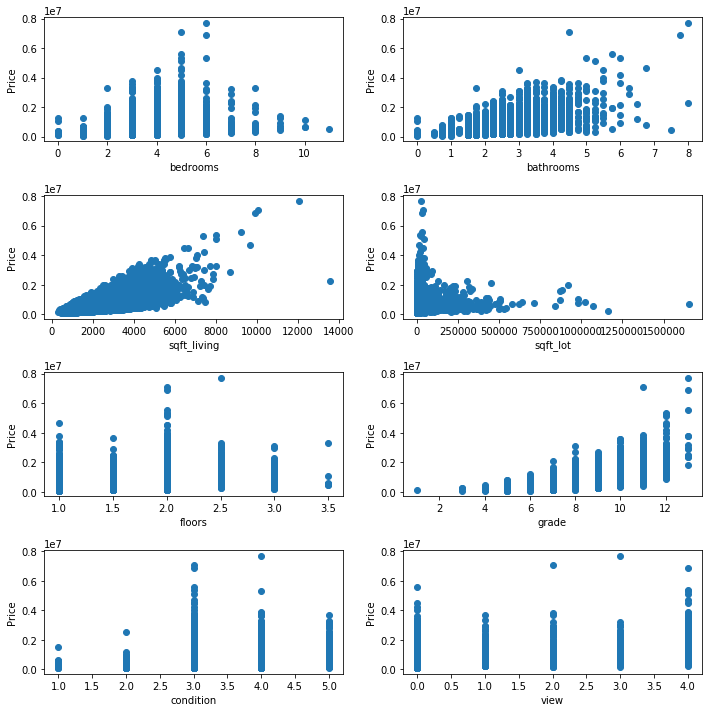

In [12]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'condition', 'view']
plt.figure(figsize=(10,10))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]], df.price)
plt.tight_layout()

* Las variables que cuantitativamente presentan una correlación con el precio son *sqft_living*, *grade* y *bathrooms*.
* Realizamos las mismas visualizaciones pero realizando un transformación del tipo raíz cuadrada de los datos:

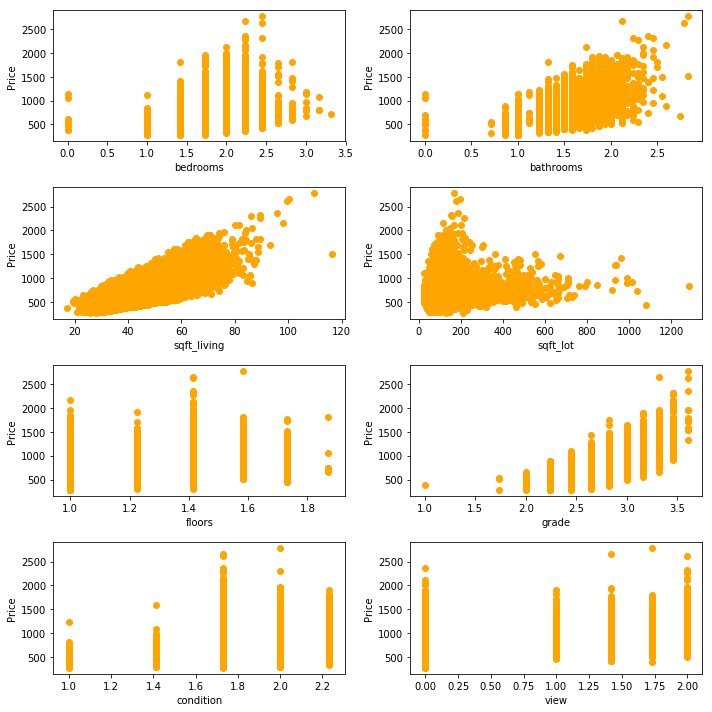

In [13]:
plt.figure(figsize=(10,10))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]].apply(np.sqrt), df.price.apply(np.sqrt), color = 'orange')
plt.tight_layout()

* Se puede ver ahora que para *sqft_living* y *sqft_lot*, los datos presentan más concentración. 
* Nuevamente realizamos una transformación antes de visualizar, ahora de tipo logarítmica:

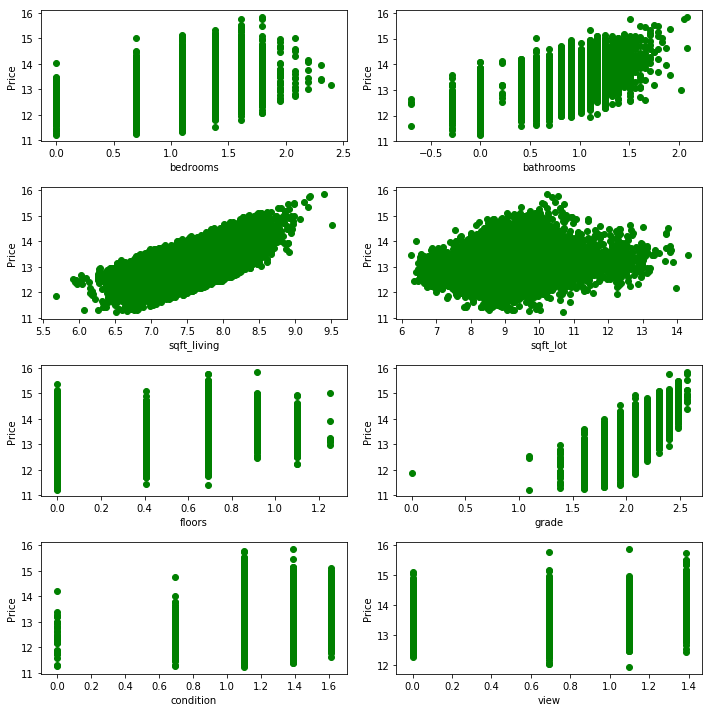

In [14]:
plt.figure(figsize=(10,10))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]].apply(np.log), df.price.apply(np.log), color = 'green')
plt.tight_layout()

* Ahora se puede apreviar mejor  *sqft_living* y *sqft_lot*, con datos menos concentrados. Por otra parte se obtiene una corroboración importante con la característica *Grade*. Dado que esta por su definición debería estar correlacionada positivamente con el precio.

* Se realiza la partición de los datos en los set de *train*, *val* y *test* para el trabajo posterior, según las proporciones $0.5/0.3/0.2$.

In [0]:
data_train, data_val_test = train_test_split(df, test_size= 0.5)
data_val, data_test = train_test_split(data_val_test, test_size= 0.4)

y_train = data_train.pop('price')
y_val = data_val.pop('price')
y_test = data_test.pop('price')

y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)


## 2.b Modelo sin regularización

* Probamos relaizar un ajuste con un modelo de de Regresión Lineal sin ningún tipo de regularización. Lo cual nos servirá de *baseline* para comparar con las técnicas posteriores.

In [16]:
from sklearn.metrics import mean_squared_error
regressor = LinearRegression()
regressor.fit(data_train.values,y_train)
   
mse_train = mean_squared_error(regressor.predict(data_train.values),y_train)
mse_val = mean_squared_error(regressor.predict(data_val.values),y_val)
mse_test = mean_squared_error(regressor.predict(data_test.values),y_test)
print("[Datos sin escalar]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)


regressor = LinearRegression(normalize=True)
regressor.fit(data_train.values,y_train)

mse_train = mean_squared_error(regressor.predict(data_train.values),y_train)
mse_val = mean_squared_error(regressor.predict(data_val.values),y_val)
mse_test = mean_squared_error(regressor.predict(data_test.values),y_test)
print("[Normalización]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)

scaler = StandardScaler()
standar_x = scaler.fit(data_train.values)

standar_data_train = standar_x.transform(data_train.values)
standar_data_val = standar_x.transform(data_val.values)
standar_data_test = standar_x.transform(data_test.values)

regressor = LinearRegression()
regressor.fit(standar_data_train,y_train)

mse_train = mean_squared_error(regressor.predict(standar_data_train),y_train)
mse_val = mean_squared_error(regressor.predict(standar_data_val),y_val)
mse_test = mean_squared_error(regressor.predict(standar_data_test),y_test)
print("[Estandarización]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)

[Datos sin escalar]
El error cuadrático medio para Train: 47310286503.22471
El error cuadrático medio para Val: 45302448963.4567
El error cuadrático medio para Test: 46590711670.76308
[Normalización]
El error cuadrático medio para Train: 47310286503.22472
El error cuadrático medio para Val: 45302448963.45369
El error cuadrático medio para Test: 46590711670.76056
[Estandarización]
El error cuadrático medio para Train: 47310286503.22472
El error cuadrático medio para Val: 45302448963.45369
El error cuadrático medio para Test: 46590711670.76057




* Con *target* estandarizado.

In [17]:
# se estandarizan los target según los precios en el set de entrenamiento
scaler = StandardScaler()
standar_y = scaler.fit(y_train)
y_train = standar_y.transform(y_train)
y_val = standar_y.transform(y_val)
y_test = standar_y.transform(y_test)

regressor = LinearRegression()
regressor.fit(data_train.values,y_train)
   
mse_train = mean_squared_error(regressor.predict(data_train.values),y_train)
mse_val = mean_squared_error(regressor.predict(data_val.values),y_val)
mse_test = mean_squared_error(regressor.predict(data_test.values),y_test)
print("[Datos sin escalar]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)


regressor = LinearRegression(normalize=True)
regressor.fit(data_train.values,y_train)

mse_train = mean_squared_error(regressor.predict(data_train.values),y_train)
mse_val = mean_squared_error(regressor.predict(data_val.values),y_val)
mse_test = mean_squared_error(regressor.predict(data_test.values),y_test)
print("[Normalización]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)

scaler = StandardScaler()
standar_x = scaler.fit(data_train.values)

standar_data_train = standar_x.transform(data_train.values)
standar_data_val = standar_x.transform(data_val.values)
standar_data_test = standar_x.transform(data_test.values)

regressor = LinearRegression()
regressor.fit(standar_data_train,y_train)

mse_train = mean_squared_error(regressor.predict(standar_data_train),y_train)
mse_val = mean_squared_error(regressor.predict(standar_data_val),y_val)
mse_test = mean_squared_error(regressor.predict(standar_data_test),y_test)
print("[Estandarización]")
print("El error cuadrático medio para Train:", mse_train)
print("El error cuadrático medio para Val:", mse_val)
print("El error cuadrático medio para Test:", mse_test)

[Datos sin escalar]
El error cuadrático medio para Train: 0.3463641132737046
El error cuadrático medio para Val: 0.3316645009808813
El error cuadrático medio para Test: 0.34109602218397944
[Normalización]
El error cuadrático medio para Train: 0.34636411327370453
El error cuadrático medio para Val: 0.33166450098086736
El error cuadrático medio para Test: 0.3410960221839681
[Estandarización]
El error cuadrático medio para Train: 0.3463641132737046
El error cuadrático medio para Val: 0.3316645009808674
El error cuadrático medio para Test: 0.3410960221839681


* Se puede ver entonces como estandarizar el *Target* marca la diferencia notablemente en relación al error cuadrático medio. Por otro lado estandarizar los datos mantiene un resultado similar con normalizar, en general el primero nos ayudaría en caso de tener muchos *outliers* dado que al dividir por la desvición estandar, disminuye su efecto negativo en la regresión.

## 2.c Regularización


* Partiendo por lo más general,  las técnicas de regularización buscan prevenir el *Overfitting*  del modelo predictivo. Así los metodos más clasicos a estudiar penalizan una de las causas, la cual vendría a ser la **complejidad del modelo**.  De esta forma la idea es que el modelo entrenado logre generalizar más respecto a características no tan específicas de los datos .Para el caso de regresión:

$$ R_{reg}(f) = R_{emp}(f) + \lambda\Omega(f) $$
$$  \hspace{5em}  = \sum _{m}^{M}R_{emp}(f) + \lambda\Omega(f) $$


* Donde  $\Omega()$ corresponde al **regularizador** y $\lambda$ es el **parámetro de regularización**.  Entonces para el caso de la regresión lineal,  se presentan 2 tipos de regularizaciones:

  * **Regularización L1 o Lasso**: En esta regularización se pretende utilizar la norma 1 respecto a los parámetros del modelo:
    $$ \Omega(w) = \frac{1}{2} |w|_{L1} = \sum_i |w_i|     $$
    * Entonces la formula respecto al error cuadrático medio queda como:
    $$  E_{reg} = E(w) + \frac{\lambda}{2}|w|_{L1}$$
    *  En general esta regularización permite llevar a 0 *features* las cuales no aporten mucho al modelo a medida que se aumente el valor del **parámetro de regularización**.
    
  * **Regularización L2 o Ridge**: Tal y como su nombre indica se diferencia por la utilización de la norma 2:
    $$ \Omega(w) = \frac{1}{2} |w|^2_{L2} =\frac{1}{2} \sum_i w_i^2     $$
    $$  E_{reg} = E(w) + \frac{\lambda}{2}||w||^2_{L2}$$
    * Es útil cuando la mayoría de las variables si entregan información de utilidad, sin embargo los valores se aproximan asintoticamente a 0.
  
* Por último $\lambda$ indica que tanto afectara la regularización al entrenamiento, es claro ver entonces que para *Lasso*  aumentar este valor, lleva las variables a ser iguales a 0.
  

## 2.d  Influencia sobre el error

* Ahora bien dado que $\lambda$ es un parámetro que se debe fijar antes de entrenar, por lo cual se debe realizar un análisis respecto al valor que debería tomar con el fin de reducir el error.

In [0]:
from sklearn.linear_model import Lasso, Ridge

In [0]:
# lambda = 0.01

#np.logspace(-2,1,100)
MSE_lasso_list = []
MSE_lasso_list_val = []
MSE_ridge_list = []
MSE_ridge_list_val = []
space = np.logspace(-3,3,100)
space = np.concatenate([0,space],axis=None)
for lambd in space:
    #warning de iteraciones
    model = Lasso(alpha=lambd,  max_iter=10e3)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_lasso_list.append(mse)
    MSE_lasso_list_val.append(mse_val)
    model = Ridge(alpha=lambd)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_ridge_list.append(mse)
    MSE_ridge_list_val.append(mse_val)

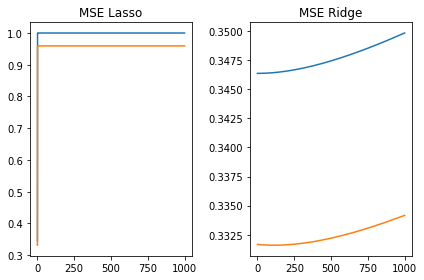

In [20]:
f, axs = plt.subplots(1, 2, sharex = True)
axs[0].plot(space, MSE_lasso_list)
axs[0].plot(space, MSE_lasso_list_val)
axs[0].set_title("MSE Lasso")
axs[1].plot(space, MSE_ridge_list)
axs[1].plot(space, MSE_ridge_list_val)
axs[1].set_title("MSE Ridge")
f.tight_layout()

* Podemos ver una pronunciación importante para Lasso en valores cercanos a 0, lo cual posiblemente se deba al cambio abrupto en el valor de los coeficientes. Donde al tener un  $\lambda$ muy grande, estos llegan a 0. Y el modelo finalmente queda constante respecto a las variables. Por otra parte para Ridge notamos un comportamiento más *suave* en la curva, lo que se esperaba de antemano, dado a que ocupa la norma 2.

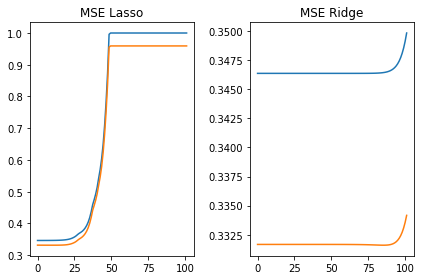

In [21]:
x = np.linspace(0,101,num=101)
f, axs = plt.subplots(1, 2, sharex = True)
axs[0].plot(x, MSE_lasso_list)
axs[0].plot(x, MSE_lasso_list_val)
axs[0].set_title("MSE Lasso")
axs[1].plot(x, MSE_ridge_list)
axs[1].plot(x, MSE_ridge_list_val)
axs[1].set_title("MSE Ridge")
f.tight_layout()

* Se visualiza ahora con puntos igualmente espaciados en el eje x, donde podemos notar el cambio abrupto producido por *Lasso*.  

### 2.d.1 Lasso

In [22]:
min_mse_i = np.where(MSE_lasso_list_val == np.amin(MSE_lasso_list_val))[0][0]
print("[Lasso] Mejor valor para lambda según MSE: " + str(space[min_mse_i]))

[Lasso] Mejor valor para lambda según MSE: 0.0030538555088334154


In [0]:
MSE_lasso_list = []
MSE_lasso_list_val = []

space_lasso = np.linspace(space[min_mse_i-3],space[min_mse_i+3],100)
for lambd in space_lasso:
    #warning de iteraciones
    model = Lasso(alpha=lambd,  max_iter=10e3)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_lasso_list.append(mse)
    MSE_lasso_list_val.append(mse_val)

Text(0.5, 1.0, 'MSE Lasso')

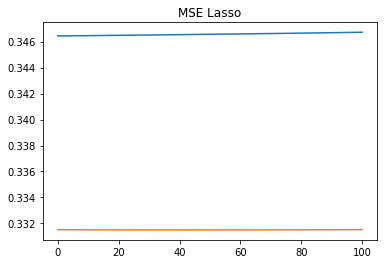

In [24]:
x = np.linspace(0,len(space_lasso),num=len(space_lasso))
plt.plot(x, MSE_lasso_list)
plt.plot(x, MSE_lasso_list_val)
plt.title("MSE Lasso")

* El mejor valor no se da en 0, sin embargo debido a la magnitud de los valores es dificil ver la curva convexa que se esperaría en la optimización del error.

### 2.4.2 Ridge

In [25]:
min_mse_i = np.where(MSE_ridge_list_val == np.amin(MSE_ridge_list_val))[0][0]
print("[Ridge] Mejor valor para lambda según MSE: " + str(space[min_mse_i]))

[Ridge] Mejor valor para lambda según MSE: 107.22672220103232


Text(0.5, 1.0, 'MSE Ridge')

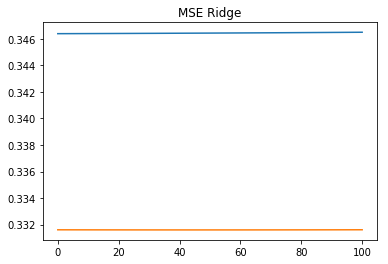

In [26]:
MSE_ridge_list = []
MSE_ridge_list_val = []

space_ridge = np.linspace(space[min_mse_i-3],space[min_mse_i+3],100)
for lambd in space_ridge:
    #warning de iteraciones
    model = Ridge(alpha=lambd,  max_iter=10e3)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_ridge_list.append(mse)
    MSE_ridge_list_val.append(mse_val)
    
    
x = np.linspace(0,len(space_ridge),num=len(space_ridge))
plt.plot(x, MSE_ridge_list)
plt.plot(x, MSE_ridge_list_val)
plt.title("MSE Ridge")

* Se procede a comparar los menores valores obtenidos para cada regularizador en el set de validación:

In [27]:
min_lasso = np.amin(MSE_lasso_list_val)
min_ridge = np.amin(MSE_ridge_list_val)

print("[Sin reg.]:" + str(mse_val))
print("[Lasso]: " + str(min_lasso))
print("[Ridge]: " + str(min_ridge))

[Sin reg.]:0.33161023025126707
[Lasso]: 0.3315040678610171
[Ridge]: 0.33159837031681794


* Los errores logrados con regularización son casi iguales a los del modelo original, se puede ver que con *Ridge* se logra un mejor resultado. Posiblemente a que la mayoría de las características aportan información, sin embargo la diferencia sigue siendo pequeña.

## 2.e Influencia sobre los coeficientes

* Ahora para el análisis veremos como son afectados las coeficientes respectivos a cada  *feature*,  respecto al cambio en $\lambda$.

### 2.e.1 Lasso

In [0]:
x_cols = data_train.columns.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871.405304017822, tolerance: 1.0805999999999998
  positive)


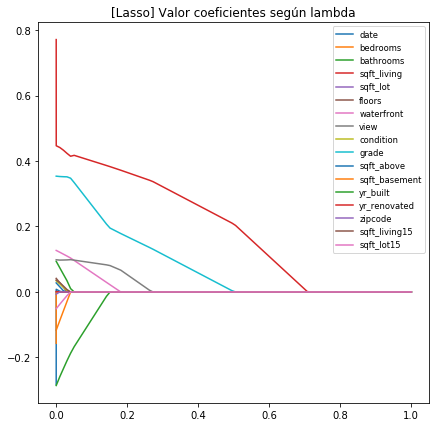

In [29]:
MSE_lasso_list = []
MSE_lasso_list_val = []
coefs_lasso = []
space = pd.np.linspace(0.0001,1,100)
space = np.concatenate([0,space],axis=None)
for lambd in space:
    #warning de iteraciones
    model = Lasso(alpha=lambd,  max_iter=10e3)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_lasso_list.append(mse)
    MSE_lasso_list_val.append(mse_val)
    coefs_lasso.append(model.coef_)

plt.figure(figsize=(7,7))
plt.title("[Lasso] Valor coeficientes según lambda")
for y_arr, label in zip(np.squeeze(coefs_lasso).T, x_cols):
    plt.plot(space, y_arr, label=label)
plt.legend(fontsize='small')    

* Podemos ver el como las características decaen a 0 a medida que aumenta el valor de $\lambda$.

### 2.e.2 Ridge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.09611e-17): result may not be accurate.
  overwrite_a=True).T


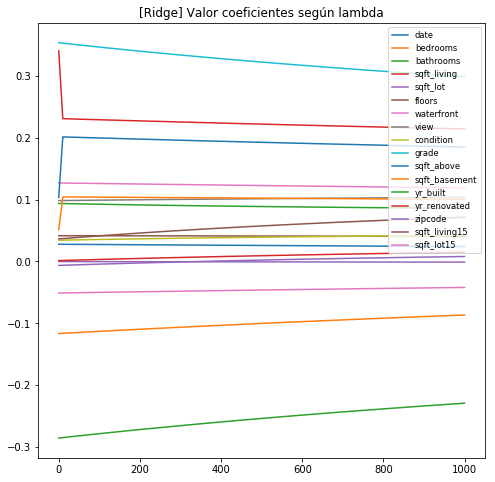

In [30]:
MSE_ridge_list = []
MSE_ridge_list_val = []
coefs_ridge = []
space = pd.np.logspace(1,3,100) 
space = np.concatenate([0,space],axis=None)
for lambd in space:
    #warning de iteraciones
    model = Ridge(alpha=lambd)
    model.fit(standar_data_train,y_train)
    mse = mean_squared_error(model.predict(standar_data_train),y_train)
    mse_val = mean_squared_error(model.predict(standar_data_val),y_val)
    MSE_ridge_list.append(mse)
    MSE_ridge_list_val.append(mse_val)
    coefs_ridge.append(model.coef_)

plt.figure(figsize=(8,8))
plt.title("[Ridge] Valor coeficientes según lambda")
for y_arr, label in zip(np.squeeze(coefs_ridge).T, x_cols):
    plt.plot(space, y_arr, label=label)
plt.legend(fontsize='small', loc=1)    

* En general las características tienden a disminuir su valor, llegando de manera asintótica a 0.

* Además del análisis anterior se incluye una métrica para la corroboración de la información entregada por las características:

In [0]:
from sklearn.feature_selection import mutual_info_regression

In [32]:
standar_data_train.shape[1]

17

In [0]:

mi_list = list()
for i in range(standar_data_train.shape[1]):
  mi_list.append(mutual_info_regression(standar_data_train[:,i].reshape(-1, 1),y_train))

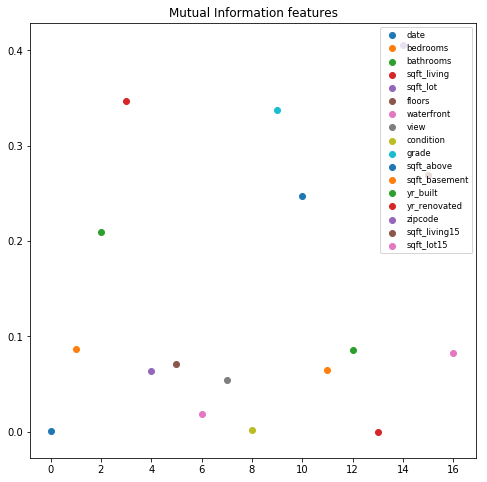

In [34]:
plt.figure(figsize=(8,8))
for i in range(standar_data_train.shape[1]):
    plt.scatter(i,mi_list[i], label=x_cols[i])
_=plt.legend(fontsize='small', loc=1)  
_=plt.title("Mutual Information features")

* Se puede ver cierta relación respecto a las características que la regresión *Lasso* eliminaba al final. A  pesar de ello esta regresión no siempre puede ser adecuada para la selección de características, dado que estara muy afectada por el *Split* realizado en los datos

## 2.f K-fold sobre $\lambda$

*  Ahora se debe ocupar K-Fold en función de ver que valor de $\lambda$ se mantiene como el mejor al generalizar (ocupar distintos train/val set). Se elige *Lasso*  al ser el que poseía mejores resultados hasta ahora.

In [0]:
from sklearn.model_selection import KFold

# se agrupan los datos en los cuales se realizará el k-fold
data_train_val, data_val_test = train_test_split(df, test_size= 0.2)



y_train_val = data_train_val.pop('price').values.reshape(-1,1)
X = data_train_val.values

kf = KFold(n_splits=5)
kf.get_n_splits(X)


mse_lasso_list_mean = np.array([])
mse_lasso_list_val_mean = np.array([])
coefs_lasso_mean = np.array([])
space = np.linspace(0,0.1,25)

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y_train_val[train_index], y_train_val[test_index]
  
 
  scaler = StandardScaler()
  scaler_x = scaler.fit(X_train)
  X_train = scaler_x.transform(X_train)
  X_test = scaler_x.transform(X_test)

  scaler = StandardScaler()
  scaler_y = scaler.fit(y_train)
  y_train = scaler_y.transform(y_train)
  y_test = scaler_y.transform(y_test)

  MSE_lasso_list = np.array([])
  MSE_lasso_list_val = np.array([])
  coefs_lasso = np.array([])
  for lambd in space:
      #warning de iteraciones
      model = Lasso(alpha=lambd)
      model.fit(X_train,y_train)
      mse = mean_squared_error(model.predict(X_train),y_train)
      mse_val = mean_squared_error(model.predict(X_test),y_test)
      MSE_lasso_list = np.concatenate((MSE_lasso_list,mse),axis=None)
      MSE_lasso_list_val = np.concatenate((MSE_lasso_list_val,mse_val), axis=None)
      coefs_lasso =  np.concatenate((coefs_lasso,model.coef_),axis=None)
  mse_lasso_list_mean = np.concatenate((mse_lasso_list_mean, MSE_lasso_list), axis= 0)
  mse_lasso_list_val_mean = np.concatenate((mse_lasso_list_val_mean, MSE_lasso_list_val), axis= 0)
  coefs_lasso_mean = np.concatenate((coefs_lasso_mean, coefs_lasso),  axis= 0)

In [36]:
model.coef_[0]

0.0

In [0]:
mse_lasso_list_mean= mse_lasso_list_mean.reshape(5,len(space))
mse_lasso_list_val_mean = mse_lasso_list_val_mean.reshape(5,len(space))
coefs_lasso_mean =  coefs_lasso_mean.reshape(5,len(space),len(model.coef_))

mse_lasso_list_mean = mse_lasso_list_mean.mean(axis = 0)
mse_lasso_list_val_mean = mse_lasso_list_val_mean.mean(axis = 0)
coefs_lasso_mean =  coefs_lasso_mean.mean(axis = 0)

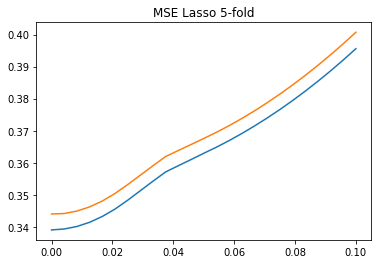

In [38]:
plt.plot(space, mse_lasso_list_mean)
plt.plot(space, mse_lasso_list_val_mean)
_= plt.title("MSE Lasso 5-fold")

In [39]:
min_mse_i = np.where(mse_lasso_list_mean == np.amin(mse_lasso_list_mean))[0][0]
print("[Lasso] Mejor valor para lambda según MSE: " + str(space[min_mse_i]))

[Lasso] Mejor valor para lambda según MSE: 0.0


* Esto es un buen indicador de que el modelo sin regularizar no posee *overfitting*, dado que en caso contrario debería mejorar con regularización. Probablemente sea una clasificación no linealmente separable, y el modelo este teniendo *underfitting*. Por lo cual dificultar más el entrenamiento no sería ventajoso.

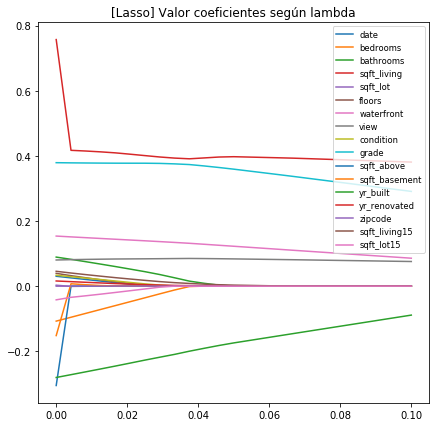

In [40]:
plt.figure(figsize=(7,7))
plt.title("[Lasso] Valor coeficientes según lambda")
for y_arr, label in zip(np.squeeze(coefs_lasso_mean).T, x_cols):
    plt.plot(space, y_arr, label=label)
plt.legend(fontsize='small')    

* Se puede ver que las mismas características de *sqft_living* y *grade* se mantienen con la mayor magnitud respecto a sus coeficientes. Esto entrega información valiosa respecto a su aporte en la predicción del *price* de la vivienda.

## 2.g Grid search para SVM

* Según nuestro análisis anterior, podemos notar que el error cuadrático medio no varia demasiado respecto a las modificaciones respecto a regularización. Sospechamos que nos podríamos encontrar ante un infame problema no separable linealmente, por lo cual probaremos el uso de SVM para realizar un ajuste más adecuado.

In [48]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train) 

mse = mean_squared_error(model.predict(X_train),y_train)
mse_val = mean_squared_error(model.predict(X_test),y_test)
print(mse)
print(mse_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2454660807499753
0.34166840431608475


In [0]:
Cs, epsilons = np.meshgrid([i for i in range(1,5)],[i/20 for i in range(1,5)])
mse_svm_list = list() 
mse_svm_val_list = list() 
score_list = list()
for C in Cs:
  for e in epsilons:
    model = SVR(C=C, epsilon=e)
    model.fit(X_train, y_train) 

    mse_svm_list.append(mean_squared_error(model.predict(X_train),y_train))
    mse_svm_val_list.append(mean_squared_error(model.predict(X_test),y_test))    

In [0]:
print(mse_svm_list)
print(mse_svm_val_list)

[0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829, 0.2470118478184829]
[0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948, 0.2435995268289948]
